# everything about mcmc  

* [gdoc](https://docs.google.com/document/d/1nRTJjX-04HCqIC4DnD4fhaEUqH8CaUhyLLF7QGvujn0/edit)

## Applications
* Benchmark problems in biology [Ballnus+2017](https://bmcsystbiol.biomedcentral.com/articles/10.1186/s12918-017-0433-1)
* oddly-shaped hypothetical distributions; see [dynesty examples](https://dynesty.readthedocs.io/en/latest/examples.html#)

## Software
* packages
 - python
   - [emcee]()
   - nestle by Kyle Barbary
   - dynesty by Josh Speagle
 - R
   - [ggmcmc](https://cran.r-project.org/web/packages/ggmcmc/); [paper](https://cran.r-project.org/web/packages/ggmcmc/vignettes/v70i09.pdf)
   
* website
 - https://github.com/mattpitkin/theonlinemcmc

https://arviz-devs.github.io/arviz/examples/index.html

## metropolis-hastings

In [2]:
import numpy as np

def metropolis_hastings_vec(log_prob, proposal_cov, iters, chains, init):
    """Vectorized Metropolis-Hastings.

    Allows scaling across chains:
    Runs 1,000 chains of 1,000 iterations each on a
    correlated 100D normal in ~5 seconds.
    """
    proposal_cov = np.atleast_2d(proposal_cov)
    dim = proposal_cov.shape[0]
    # Initialize with a single point, or an array of shape (chains, dim)
    if init.shape == (dim,):
        init = np.tile(init, (chains, 1))

    samples = np.empty((iters, chains, dim))
    samples[0] = init
    current_log_prob = log_prob(init)

    proposals = np.random.multivariate_normal(np.zeros(dim), proposal_cov,
                                              size=(iters - 1, chains))
    log_unifs = np.log(np.random.rand(iters - 1, chains))
    for idx, (sample, log_unif) in enumerate(zip(proposals, log_unifs), 1):
        proposal = sample + samples[idx - 1]
        proposal_log_prob = log_prob(proposal)
        accept = (log_unif < proposal_log_prob - current_log_prob)

        # copy previous row, update accepted indexes
        samples[idx] = samples[idx - 1]
        samples[idx][accept] = proposal[accept]

        # update log probability
        current_log_prob[accept] = proposal_log_prob[accept]
    return samples

In [3]:
import scipy.stats as st

dim = 10
Σ = 0.1 * np.eye(dim) + 0.9 * np.ones((dim, dim))

# Correlated Gaussian
log_prob = st.multivariate_normal(np.zeros(dim),  Σ).logpdf

proposal_cov = np.eye(dim)
iters = 2_000
chains= 1_024
init = np.zeros(dim)

samples = metropolis_hastings_vec(log_prob, proposal_cov, iters, chains, init)

In [5]:
samples.shape

(2000, 1024, 10)

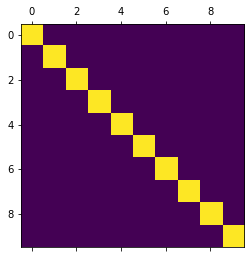

In [8]:
import matplotlib.pyplot as pl

pl.matshow(Σ)

## without covariance

In [10]:
import pymc3 as pm
import time
import matplotlib.pyplot as pl
import numpy as np
from corner import corner
np.random.seed(42)

In [17]:
ndim = 5
with pm.Model() as simple_model:
    pm.Normal("x", shape=(ndim,))

strt = time.time()
with simple_model:
    simple_trace = pm.sample(draws=3000, tune=3000, random_seed=42)
    
    # About half the time is spent in tuning so correct for that
    simple_time = 0.5*(time.time() - strt)
    
stats = pm.summary(simple_trace)
simple_time_per_eff = simple_time / stats.n_eff.min()
print("time per effective sample: {0:.5f} ms".format(simple_time_per_eff * 1000))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [00:06<00:00, 3958.51draws/s]


## with covariance

In [2]:
L = np.random.randn(ndim, ndim)
L[np.diag_indices_from(L)] = 0.1*np.exp(L[np.diag_indices_from(L)])
L[np.triu_indices_from(L, 1)] = 0.0
cov = np.dot(L, L.T)

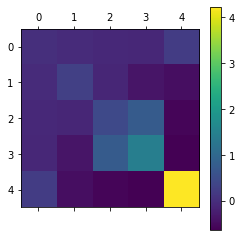

In [7]:
ax = pl.matshow(cov)
pl.colorbar(ax)

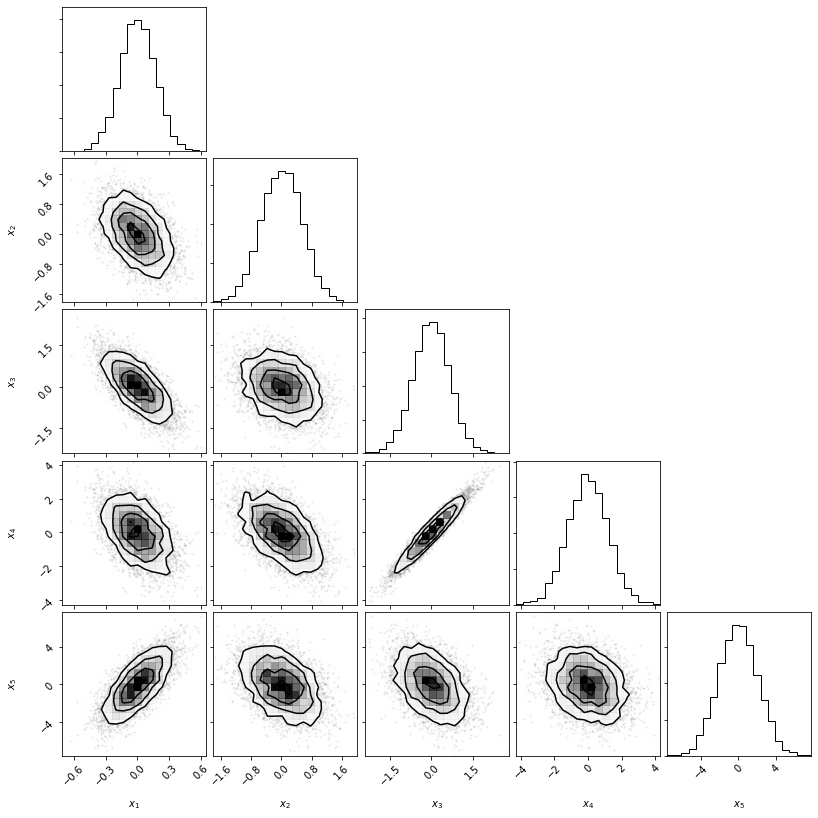

In [5]:
# Draw samples from this Gaussian and plot
samples = np.random.multivariate_normal(np.zeros(ndim), cov, size=5000)
corner(samples, labels=[f"$x_{{{i}}}$" for i in range(1, ndim+1)]);

## sampling with pymc3

In [ ]:
#slow
with pm.Model() as model:
    #multivariate normal
    pm.MvNormal("x", mu=np.zeros(ndim), chol=L, shape=(ndim,))

with model:
    strt = time.time()
    default_trace = pm.sample(draws=10000, tune=5000, random_seed=42)
    default_time = 0.5 * (time.time() - strt)

stats = pm.summary(default_trace)
# default_time_per_eff = default_time / stats.n_eff.min()
# print("time per effective sample: {0:.5f} ms".format(default_time_per_eff * 1000))

In [18]:
n_start = 25
n_burn = 500
n_tune = 5000
n_window = n_start * 2 ** np.arange(np.floor(np.log2((n_tune - n_burn) / n_start)))
n_window = np.append(n_window, n_tune - n_burn - np.sum(n_window))
n_window = n_window.astype(int)

In [19]:
from pymc3.step_methods.hmc.quadpotential import QuadPotentialFull

def get_step_for_trace(trace=None, model=None,
                       regular_window=5, regular_variance=1e-3,
                       **kwargs):
    model = pm.modelcontext(model)
    
    # If not given, use the trivial metric
    if trace is None:
        potential = QuadPotentialFull(np.eye(model.ndim))
        return pm.NUTS(potential=potential, **kwargs)
        
    # Loop over samples and convert to the relevant parameter space;
    # I'm sure that there's an easier way to do this, but I don't know
    # how to make something work in general...
    samples = np.empty((len(trace) * trace.nchains, model.ndim))
    i = 0
    for chain in trace._straces.values():
        for p in chain:
            samples[i] = model.bijection.map(p)
            i += 1
    
    # Compute the sample covariance
    cov = np.cov(samples, rowvar=0)
    
    # Stan uses a regularized estimator for the covariance matrix to
    # be less sensitive to numerical issues for large parameter spaces.
    # In the test case for this blog post, this isn't necessary and it
    # actually makes the performance worse so I'll disable it, but I
    # wanted to include the implementation here for completeness
    N = len(samples)
    cov = cov * N / (N + regular_window)
    cov[np.diag_indices_from(cov)] += \
        regular_variance * regular_window / (N + regular_window)
    
    # Use the sample covariance as the inverse metric
    potential = QuadPotentialFull(cov)
    return pm.NUTS(potential=potential, **kwargs)

In [22]:
 stats.ess_mean

x[0]    31877.0
x[1]    29670.0
x[2]    29647.0
x[3]    28626.0
x[4]    34300.0
Name: ess_mean, dtype: float64

In [20]:
np.random.seed(42)

strt = time.time()
with model:
    start = None
    burnin_trace = None
    for steps in n_window:
        step = get_step_for_trace(burnin_trace, regular_window=0)
        burnin_trace = pm.sample(
            start=start, tune=steps, draws=2, step=step,
            compute_convergence_checks=False, discard_tuned_samples=False)
        start = [t[-1] for t in burnin_trace._straces.values()]

    step = get_step_for_trace(burnin_trace, regular_window=0)
    dense_trace = pm.sample(draws=5000, tune=n_burn, step=step, start=start)
    factor = 5000 / (5000 + np.sum(n_window+2) + n_burn)
    dense_time = factor * (time.time() - strt)

stats = pm.summary(dense_trace)
# dense_time_per_eff = dense_time / stats.n_eff.min()
# print("time per effective sample: {0:.5f} ms".format(dense_time_per_eff * 1000))

Only 2 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]
Sampling 4 chains, 0 divergences: 100%|██████████| 108/108 [00:01<00:00, 96.69draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only 2 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]
Sampling 4 chains, 0 divergences: 100%|██████████| 208/208 [00:00<00:00, 504.59draws/s]
Only 2 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]
Sampling 4 chains, 0 divergences: 100%|██████████| 408/408 [00:00<00:00, 1277.33draws/s]
Only 2 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NU

AttributeError: 'DataFrame' object has no attribute 'n_eff'

### emcee

In [3]:
import numpy as np
import emcee
import arviz as az

eight_school_data = {
    'J': 8,
    'y': np.array([28., 8., -3., 7., -1., 1., 18., 12.]),
    'sigma': np.array([15., 10., 16., 11., 9., 11., 10., 18.])
}

def log_prior_8school(theta,J):
    mu = theta[0]
    tau = theta[1]
    eta = theta[2:]
    # Half-cauchy prior
    if tau<0:
        return -np.inf
    hwhm = 25
    prior_tau = -np.log(tau**2+hwhm**2)
    prior_mu = -(mu/10)**2  # normal prior, loc=0, scale=10
    prior_eta = -np.sum(eta**2)  # normal prior, loc=0, scale=1
    return prior_mu + prior_tau + prior_eta

def log_likelihood_8school(theta,y,sigma):
    mu = theta[0]
    tau = theta[1]
    eta = theta[2:]
    return -np.sum(((mu + tau * eta - y) / sigma)**2)

def lnprob_8school(theta,J,y,sigma):
    prior = log_prior_8school(theta,J)
    if prior <= -np.inf:
        return -np.inf
    like = log_likelihood_8school(theta,y,sigma)
    return like+prior

nwalkers = 40
ndim = eight_school_data['J']+2
draws = 1500
pos = np.random.normal(size=(nwalkers,ndim))
pos[:,1] = np.absolute(pos[:,1])
sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    lnprob_8school,
    args=(
        eight_school_data['J'],
        eight_school_data['y'],
        eight_school_data['sigma']
    )
)
sampler.run_mcmc(pos, draws)

# define variable names, it cannot be inferred from emcee
var_names = ['mu','tau']+['eta{}'.format(i) for i in range(eight_school_data['J'])]
emcee_data = az.from_emcee(sampler, var_names = var_names)
emcee_data

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

### pymc3

In [5]:
import pymc3 as pm
draws = 500
chains = 2

eight_school_data = {
    'J': 8,
    'y': np.array([28., 8., -3., 7., -1., 1., 18., 12.]),
    'sigma': np.array([15., 10., 16., 11., 9., 11., 10., 18.])
}

with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta_tilde = pm.Normal('theta_tilde', mu=0, sd=1, shape=eight_school_data['J'])
    theta = pm.Deterministic('theta', mu + tau * theta_tilde)
    pm.Normal('obs', mu=theta, sd=eight_school_data['sigma'], observed=eight_school_data['y'])

    trace = pm.sample(draws, chains=chains)
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)

    pm_data = az.from_pymc3(
            trace=trace,
            prior=prior,
            posterior_predictive=posterior_predictive,
            coords={'school': np.arange(eight_school_data['J'])},
            dims={'theta': ['school'], 'theta_tilde': ['school']},
        )
pm_data

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta_tilde, tau, mu]
100%|██████████| 1000/1000 [00:00<00:00, 1485.30it/s]


Inference data with groups:
	> posterior
	> sample_stats
	> log_likelihood
	> posterior_predictive
	> observed_data
	> prior
	> prior_predictive

### pyro

In [4]:
import torch

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive

pyro.enable_validation(True)
pyro.set_rng_seed(0)

draws = 500
chains = 2
eight_school_data = {
    'J': 8,
    'y': torch.tensor([28., 8., -3., 7., -1., 1., 18., 12.]),
    'sigma': torch.tensor([15., 10., 16., 11., 9., 11., 10., 18.])
}

def model(J, sigma, y=None):
    mu = pyro.sample('mu', dist.Normal(0, 5))
    tau = pyro.sample('tau', dist.HalfCauchy(5))
    with pyro.plate('J', J):
        theta_tilde = pyro.sample('theta_tilde', dist.Normal(0, 1))
        theta = mu + tau * theta_tilde
        return pyro.sample("obs", dist.Normal(theta, sigma), obs=y)

nuts_kernel = NUTS(model, jit_compile=True, ignore_jit_warnings=True)
mcmc = MCMC(nuts_kernel, num_samples=draws, warmup_steps=draws,
            num_chains=chains, disable_progbar=True)
mcmc.run(**eight_school_data)
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model, posterior_samples).get_samples(
    eight_school_data['J'], eight_school_data['sigma']
)
prior = Predictive(model, num_samples=500).get_samples(
    eight_school_data['J'], eight_school_data['sigma']
)

pyro_data = az.from_pyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={'school': np.arange(eight_school_data['J'])},
    dims={'theta': ['school']}
)
pyro_data

ModuleNotFoundError: No module named 'torch'